# Proyecto 1: ONU ODS

- Juan Camilo Colmenares - 202011866
- Juan Montealegre - 20201723
- David Gonzales - 201815834

El objetivo de este proyecto es pasar 

In [143]:
import numpy as np
import pandas as pd

import re, os, string, time

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import word_tokenize, sent_tokenize

import inflect


from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline

import contractions
import seaborn as sns; sns.set()  # for plot styling


import matplotlib.pyplot as plt
import timeit

nltk.download('wordnet')
nltk.download('words')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

stop_words = stopwords.words('spanish')
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmer = nltk.stem.WordNetLemmatizer()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juank\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\juank\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juank\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\juank\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juank\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [144]:
# pd.set_option("display.max_colwidth", None)

In [145]:
# nltk.download("punkt")
# nltk.download("stopwords")
# stopwords = stopwords.words("spanish")

In [146]:
df = pd.read_excel("data/cat_6716.xlsx")

## 1. Entendimiento de datos

In [147]:
df.shape

(3000, 2)

In [148]:
df.sample(5)

,Textos_espanol,sdg
1017,"El Plan del Sector Energético de Samoa 2012-2016 estableció un plan para lograr resultados consistentes con la SDS, con el objetivo general de aumentar la autosuficiencia energética. Aún no se ha publicado un nuevo plan del sector energético. La Ley de Electricidad de 2010 introdujo cambios regulatorios clave para permitir la entrada de los IPP del sector privado y contribuirá al logro del 50 por ciento de generación de electricidad renovable una vez que se completen los proyectos actuales.",7
1163,"En caso de que la VRE de una región tenga una producción remolona, otras regiones que experimenten un exceso de generación pueden transmitir la electricidad sobrante. En 2009, Alemania produjo 592 TWh de electricidad3, lo que da un consumo medio de electricidad de unos 826 W per cápita4, lo que implica que una ciudad de un millón de habitantes necesita por término medio casi 1 GW de suministro eléctrico, con variaciones considerables. El proyecto de transmisión de mayor capacidad que se está construyendo es de unos 7,2 GW de línea aérea de corriente continua de alto voltaje (HVDC)5, que podría sen/istrar a una región de unos diez millones de habitantes. La transmisión de energía hidroeléctrica a larga distancia es habitual en Brasil, China e India, debido al bajo coste de la electricidad y a la ubicación remota de las centrales hidroeléctricas. La capacidad actual de almacenamiento de electricidad suele ser casi insignificante en comparación con la generación instantánea de energía y debido a la transmisión de energía casi instantánea.",7
699,"Una forma en que la escasez de agua podría reflejarse en los precios del agua sería vincularlos a indicadores de escasez de agua en las cuencas fluviales pertinentes. De hecho, con la implementación del último Plan Hidrológico Nacional se ha desarrollado un sistema de tales indicadores que permite determinar el desarrollo de los recursos hídricos en tiempo real. La legislación actual no crea ningún espacio para el cobro de los costos ambientales de las extracciones de agua que resultan de los cambios en los flujos de agua, la morfología de los ríos o la calidad del agua y sus impactos en la salud humana y los ecosistemas, aunque esto es requerido por la Directiva Marco Europea del Agua.",6
459,"A medida que se agotan los recursos de agua subterránea, los que se encuentran en los asentamientos informales son los más afectados de inmediato. Los pequeños agricultores de la gobernación de Sana'a también son vulnerables dado que las aguas subterráneas, que representan su principal fuente de ingresos, se están agotando a un ritmo más rápido cada año que pasa, lo que obliga a las comunidades a reubicarse. Sin embargo, para la ciudad en su conjunto, incluidos los asentamientos informales, sería fácil asegurar la fuente de agua potable mediante la reasignación del 5 al 10 por ciento de la cuota de riego en la cuenca para el suministro doméstico. Se necesitan algunas inversiones físicas e incentivos económicos para aplicar esta solución.",6
1675,"También permitió a los gobiernos eludir los desafíos de coordinación a través de la planificación y el diseño de sistemas centralizados. Desde la crisis del petróleo de 1973, también ha sido ampliamente reconocido como un recurso estratégico. La seguridad energética, definida por la Agencia Internacional de la Energía (AIE) como “la disponibilidad ininterrumpida de fuentes de energía a un precio asequible”, es, por lo tanto, una prioridad importante, cuya ausencia amenaza con graves impactos económicos y sociales.",7


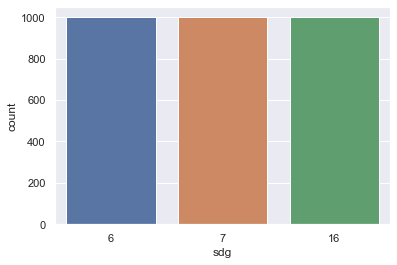

In [149]:
ax = sns.countplot(x='sdg', data=df)

In [150]:
df['document_lengths'] = np.array(list(map(len, df['Textos_espanol'].str.split(' '))))

Average number of words in Textos_espanol: 119.53733333333334.
Minimum number of words in Textos_espanol: 24.
Maximum number of words in Textos_espanol: 266.


C:\Users\juank\AppData\Local\Temp\ipykernel_17992\2379946643.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.document_lengths, bins=50, ax=ax)


<Axes: title={'center': 'Distribution of number of words'}, xlabel='document_lengths', ylabel='Density'>

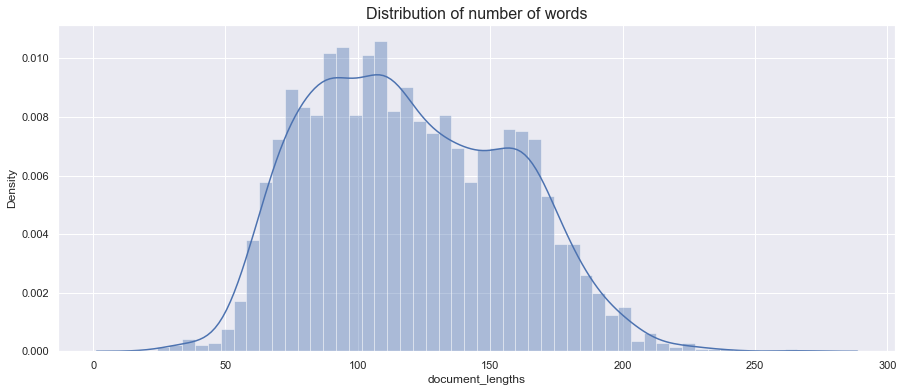

In [151]:
print("Average number of words in Textos_espanol: {}.".format(np.mean(df.document_lengths)))
print("Minimum number of words in Textos_espanol: {}.".format(min(df.document_lengths)))
print("Maximum number of words in Textos_espanol: {}.".format(max(df.document_lengths)))
## Distribution of number of words
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(df.document_lengths, bins=50, ax=ax)


In [152]:
dist_per_target= pd.pivot_table(df, values='document_lengths', index=['sdg'], aggfunc={'document_lengths': [np.mean, min, max,np.std]})
dist_per_target

,max,mean,min,std
sdg,,,,
6,239,107.351,42,34.255061
7,234,107.681,35,34.098239
16,266,143.580,24,31.996615


In [153]:
stopwords

<WordListCorpusReader in 'C:\\Users\\juank\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>

## 2. Preparación de los datos

In [154]:
 def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# def replace_numbers(words):
#     """Replace all interger occurrences in list of tokenized words with textual representation"""
#     p = inflect.engine()
#     new_words = []
#     for word in words:
#         if word.isdigit():
#                 new_word = p.number_to_words(word)
#                 new_words.append(new_word)
#         else:
#             new_words.append(word)
#     return new_words

def get_wordnet_pos(word):
    #Map POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def tokenize(text):
    text=re.sub('\\n', '. ', text)
    text=re.sub('\s+', ' ', text)
    text = re.sub(r' x+','', text)
    text = re.sub(r' X+','', text)
    text = re.sub(r'^x+ ',' ', text)
    text = re.sub(r'^X+ ','', text)
    result=sent_tokenize(text)
    return result if len(result) else np.NaN

def LemTokens(tokens):
    tokens = [token for token in tokens if token not in stop_words] 
    return [lemmer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

def LemNormalize(text):
     return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

def normalize(sent_list):
    return [" ".join(LemNormalize(s)) for s in sent_list]

# def remove_stopwords(words):
#     """Remove stop words from list of tokenized words"""

# def preprocessing(words):
#     words = to_lowercase(words)
#     words = replace_numbers(words)
#     words = remove_punctuation(words)
#     words = remove_non_ascii(words)
#     words = remove_stopwords(words)
#     return words

In [155]:
df['text2']= df['Textos_espanol'].apply(tokenize)
df['text3']= df['text2'].apply(normalize)
df['text5'] = df['text3'].apply(lambda x: " ".join(x))

In [156]:
df["sdg"].value_counts(dropna=False, normalize=True)

6     0.333333
7     0.333333
16    0.333333
Name: sdg, dtype: float64

In [167]:
df["text5"]=df["text5"].astype(str)

In [158]:
df['Textos_espanol'] = df['Textos_espanol'].apply(contractions.fix) #Aplica la corrección de las contracciones 

In [160]:
# df['words'] = df['Textos_espanol'].apply(word_tokenize).apply(preprocessing) #Aplica la eliminación del ruido
# df.head()

In [168]:
X_train, X_test, y_train, y_test = train_test_split(df[["text5"]], df["sdg"], test_size=0.3, stratify=df["sdg"], random_state=1)

In [169]:
X_train.shape, X_test.shape

((2100, 1), (900, 1))

In [170]:
pd.Series(y_train).value_counts(normalize=True)

7     0.333333
6     0.333333
16    0.333333
Name: sdg, dtype: float64

In [171]:
pd.Series(y_test).value_counts(normalize=True)

6     0.333333
7     0.333333
16    0.333333
Name: sdg, dtype: float64

In [174]:
bow = CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [175]:
X_bow = bow.fit_transform(X_train["text5"])

c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [176]:
print("Vocabulary size:", len(bow.vocabulary_))

Vocabulary size: 17975


## Training a model with BoW

In [177]:
bow_model = RandomForestClassifier(random_state=2)

In [178]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<Axes: >

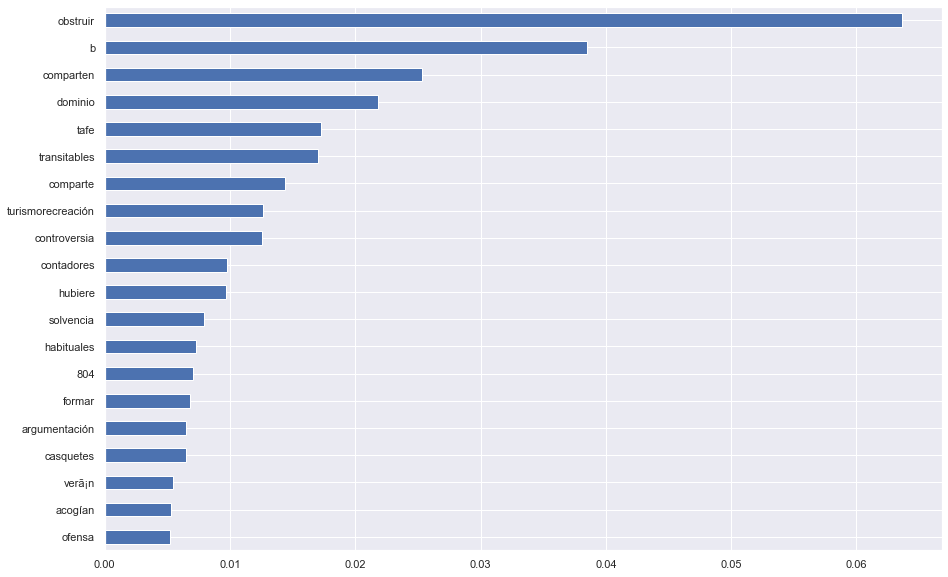

In [179]:
pd.Series(bow_model.feature_importances_, index=bow.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [180]:
bow_estimators = bow_model.estimators_
print("Number of trees:", len(bow_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 100.14


In [182]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test["text5"]))

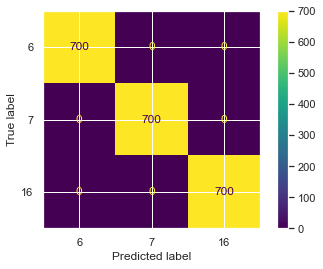

In [183]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

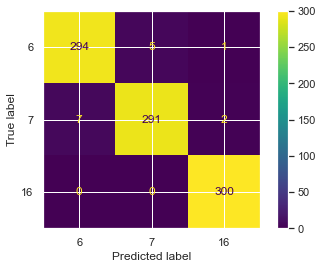

In [184]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [186]:
print("Precision Score : ",precision_score(y_test, y_test_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, y_test_bow_predict, 
                                           pos_label='positive',
                                           average='micro'))

Precision Score :  0.9833333333333333
Recall Score :  0.9833333333333333


c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
